## Analysis Of Few Image Segmentation Algorithms

In [ ]:
#importing Required Libraries

from matplotlib.image import imread
from scipy.ndimage.filters import convolve
import matplotlib.pyplot as plt
import scipy.ndimage as nd
import pandas as pd
import numpy as np
import math
import cv2

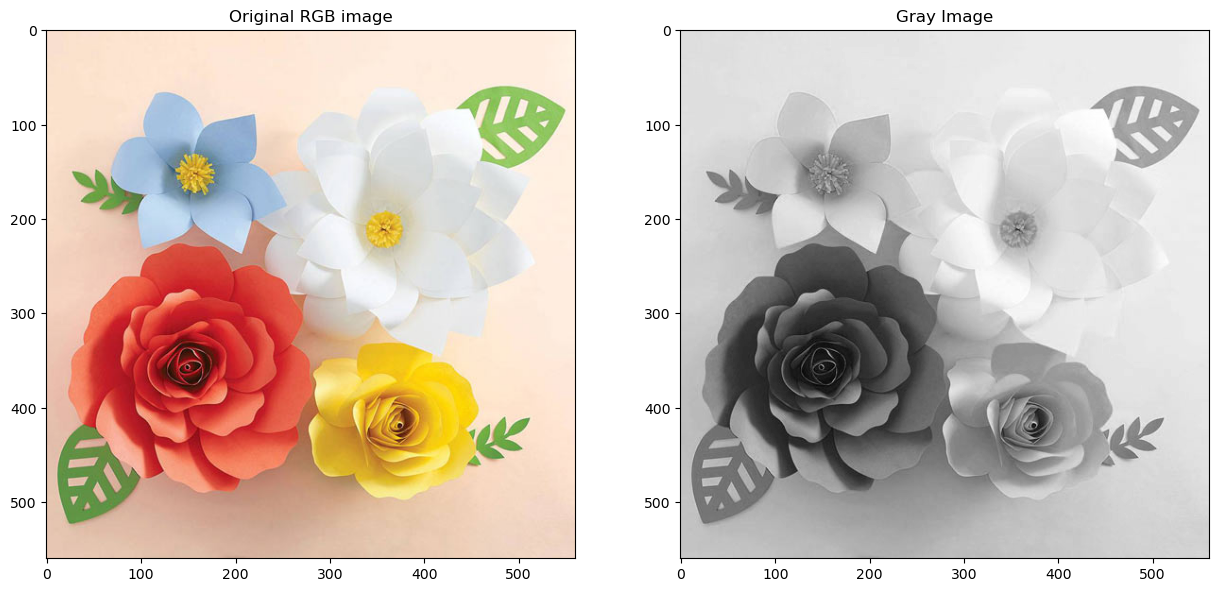

In [2]:
# Preparing Image for Segementation
# Grayscaling Image using method of luminance

my_image = imread("test_image.jpg")                    # Image Path for any image to test
B, G, R = my_image[:,:,0],my_image[:,:,1],my_image[:,:,2]
p = 1
w1, w2, w3 = 0.2990, 0.5870 , 0.1140
my_image_grayscale = w1*R**p + w2*G**p + w3*B**p
fig = plt.figure(figsize=(15,15))
fig.add_subplot(121)
plt.imshow(my_image)
plt.title("Original RGB image")
fig.add_subplot(122)
plt.imshow(my_image_grayscale, cmap = plt.cm.get_cmap('gray'))
plt.title("Gray Image")
plt.show()
test = cv2.resize(my_image_grayscale, (256, 256))

In [3]:
# 2D convolution: Extracted From my project-I

def my_convolution(any_image, gauss_kernel):

    print("\033[1m  Conv. Output Features:  \033[0m")
    kernel = np.flipud(np.fliplr(gauss_kernel))   
                                                                                      
    gauss_kernel_row, gauss_kernel_col = kernel.shape
    print( "kernel size : " , gauss_kernel.shape)

    img_row, img_col = any_image.shape
    print( "image size :", any_image.shape)

    output_conv = np.zeros(any_image.shape)
    # print( "intial output :", output_conv)

    pad_height = int((gauss_kernel_row - 1) / 2)
    print( "pad height :", pad_height)

    pad_width = int((gauss_kernel_col - 1) / 2)
    print( "pad width :", pad_width)
    
    image_padd = np.zeros((img_row + (2 * pad_height), img_col + (2 * pad_width)))                                                 # padded image intiialization
    image_padd[pad_height:image_padd.shape[0] - pad_height, pad_width:image_padd.shape[1] - pad_width] = any_image                 # inner portion of padded image replaced by original/input image
                                                                                                                                         
    for i in range(img_row):
        for j in range(img_col):
            output_conv[i, j] = np.sum(kernel * image_padd[i:i + gauss_kernel_row, j:j + gauss_kernel_col])                  # Convolution Operation(multiplications and sum)

    return output_conv

  Conv. Output Features:  
kernel size :  (5, 5)
image size : (560, 560)
pad height : 2
pad width : 2


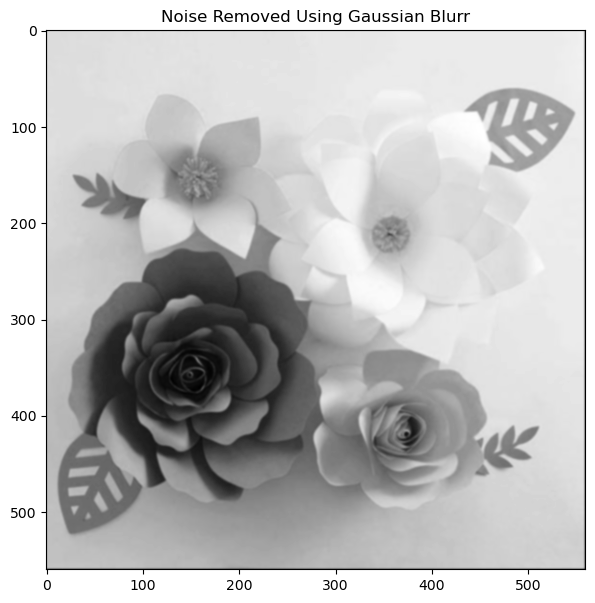

In [4]:
# Noise Removal Using Gaussian Blur

def gaussian_func(sig, kernel_size):
  a = kernel_size[ 0 ]
  b = kernel_size[ 1 ]
  x,y = np.arange((-(a-1)/2),a/2) , np.arange((-(b-1)/2),b/2)
  X,Y = np.meshgrid(x,y)
  gauss =  (np.exp(-(X ** 2 + Y ** 2 )/(2 * sig ** 2)))/ ( 2 * math.pi * sig ** 2 )
  # fig = plt.figure(figsize=(5,5))
  # fig.add_subplot()
  # plt.imshow(gauss, cmap = 'gray')
  # plt.title("Gaussian Kernel")
  return gauss/gauss.sum()
  
def gaussian_blur(image):
    kernel = gaussian_func(1.00, (5,5))                       
    return my_convolution(image, kernel)

noise_removed_image = gaussian_blur(my_image_grayscale)
fig = plt.figure(figsize=(7,7))
plt.imshow(noise_removed_image, cmap = 'gray')
plt.title("Noise Removed Using Gaussian Blurr")
plt.show()    

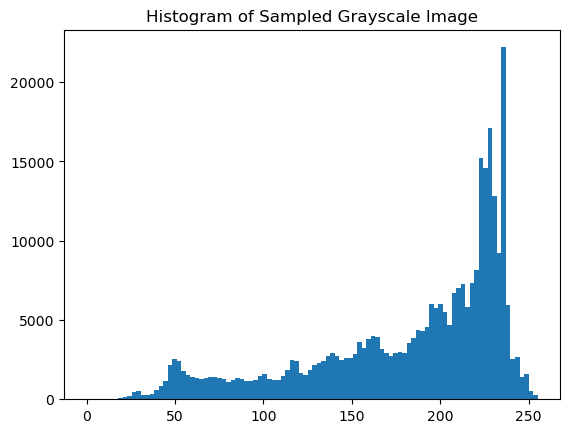

In [5]:
# 1a. Simple Thresholding Based Image Segmentation(Manual-histogram based)

fig = plt.figure()
plt.hist(noise_removed_image.flat, bins=100, range=(0,255))
plt.title("Histogram of Sampled Grayscale Image")
plt.show()

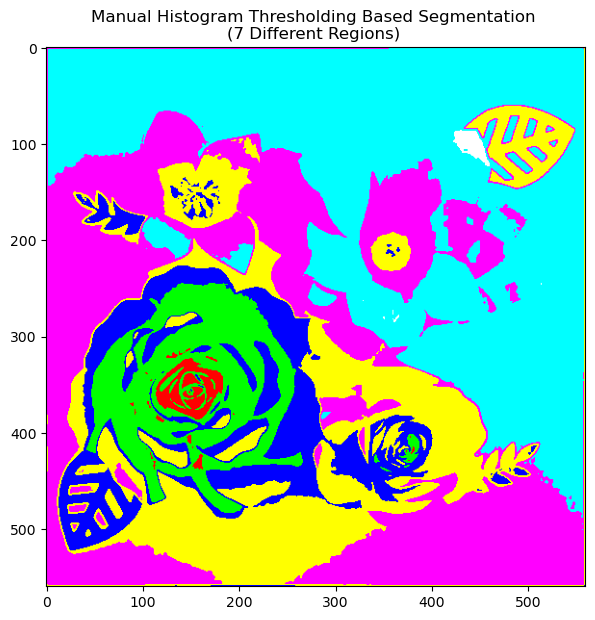

In [6]:
#  From histogram we can see that there are multiple threshold regions (40, 80, 130, 180, 220, 250 )-----> & regions

region_1 = (noise_removed_image>=0) & (noise_removed_image<40)
region_2 = (noise_removed_image>=40) & (noise_removed_image<80)
region_3 = (noise_removed_image>=80) & (noise_removed_image<130)
region_4 = (noise_removed_image>=130) & (noise_removed_image<180)
region_5 = (noise_removed_image>=180) & (noise_removed_image<220)
region_6 = (noise_removed_image>=220) & (noise_removed_image<250)
region_7 = (noise_removed_image>=250)

output_regions = np.zeros((noise_removed_image.shape[0], noise_removed_image.shape[1], 3))
output_regions[region_1] = (1,0,0)
output_regions[region_2] = (0,1,0)
output_regions[region_3] = (0,0,1)
output_regions[region_4] = (1,1,0)
output_regions[region_5] = (1,0,1)
output_regions[region_6] = (0,1,1)
output_regions[region_7] = (1,1,1)
fig = plt.figure(figsize=(7,7))
plt.title("Manual Histogram Thresholding Based Segmentation \n(7 Different Regions) ")
plt.imshow(output_regions)
plt.show()

c:\Users\15854\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


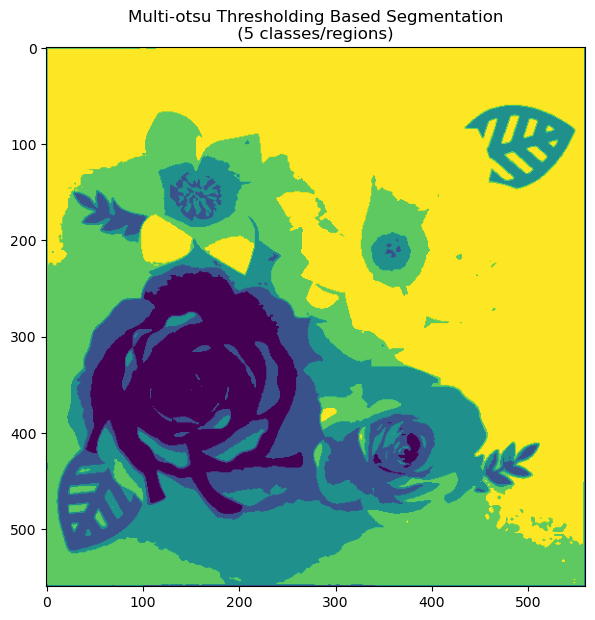

In [7]:
# 1b. Using Multi-otsu Thresholding(automatic thresholding - 5 classes)

from skimage.filters import threshold_multiotsu
threshold_values = threshold_multiotsu(noise_removed_image, classes = 5)
segment_regions = np.digitize(noise_removed_image, bins = threshold_values)
fig = plt.figure(figsize=(7,7))
plt.imshow(segment_regions)
plt.title("Multi-otsu Thresholding Based Segmentation\n (5 classes/regions) ")
plt.show()

segmented_op 0.0
checked_op 0.0
[(19, 25), (20, 24), (21, 25), (20, 26)]


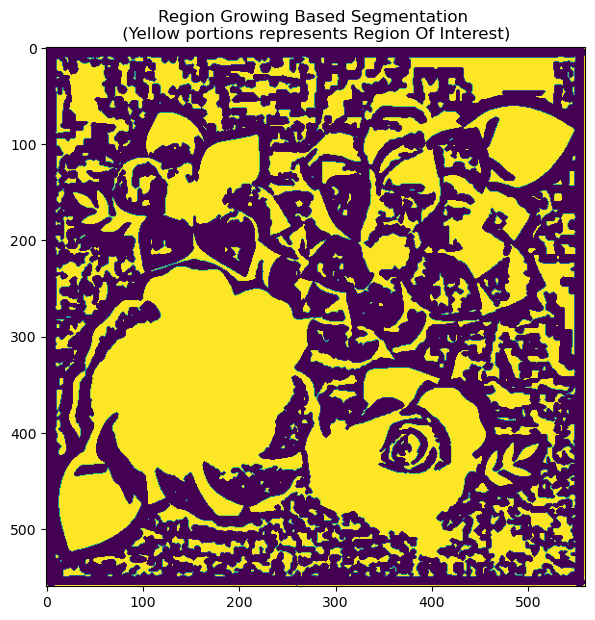

In [8]:
## 2. Region-Growing Based Segmentation(search on the 4 neighbors- starting with seed pixel and conquering new pixels if that pixel is similar to the average of current region)

def region_growing(input_img, seed, thresh):                                                 ## thresh is the threshold
    
    seg_output = np.ones(input_img.shape)
    checking = seg_output
    seg_output[seed] = False
    print("segmented_op", seg_output[seed])
    checking[seed] = False
    print("checked_op", checking[seed])
    needs_checking = get_neighbors(seed, checking, input_img.shape)
    print(needs_checking)

    while len(needs_checking)> 0:
        pix = needs_checking.pop()
        checking[pix] = False
        row_min = max(pix[0]-thresh, 0)
        row_max = min(pix[0]+thresh, input_img.shape[0]-1)
        col_min = max(pix[1]-thresh, 0)
        col_max = min(pix[1]+thresh, input_img.shape[1]-1)

        if input_img[pix] >= input_img[row_min:row_max+1, col_min:col_max+1].mean():
            seg_output[pix] = False
            needs_checking += get_neighbors(pix, checking, input_img.shape)
    return seg_output

def get_neighbors(s_point, checking, img_shape):
    neighbors = []
    if (s_point[0] > 0) and  checking[s_point[0]-1, s_point[1]]:
        neighbors.append((s_point[0]-1, s_point[1]))
    if (s_point[1] > 0) and checking[s_point[0], s_point[1]-1]:
        neighbors.append((s_point[0], s_point[1]-1))

    if (s_point[0] < img_shape[0]-1) and  checking[s_point[0]+1, s_point[1]]:
        neighbors.append((s_point[0]+1, s_point[1]))
    if (s_point[1] < img_shape[1]-1) and  checking[s_point[0], s_point[1]+1]:
        neighbors.append((s_point[0], s_point[1]+1))
        
    return neighbors

image_seed = (20,25)
growing_output = region_growing(noise_removed_image, image_seed, 8)
plt.figure(figsize=(7,7))
plt.imshow(growing_output)
plt.title("Region Growing Based Segmentation \n (Yellow portions represents Region Of Interest) ")
plt.show()

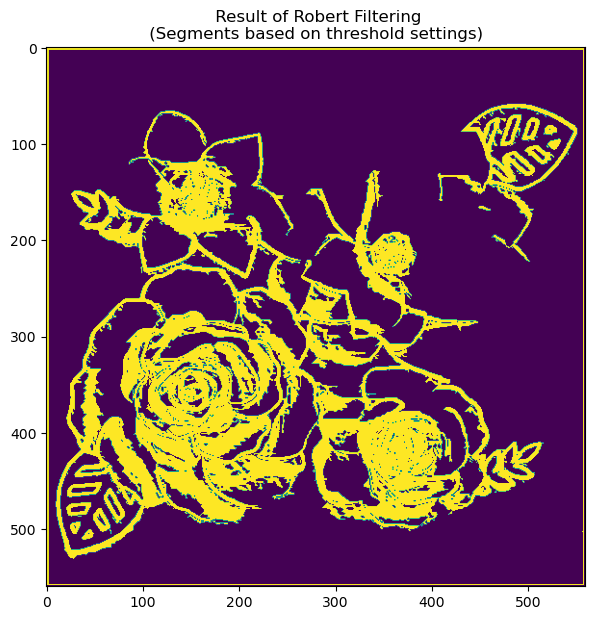

In [9]:
# 3. Edge Detection Based Segmentation
# Using Robert Operator

from scipy import ndimage as ndi

def thresholding(input_image, low_value, high_value, weak_value ):

    thresh_output = np.zeros(input_image.shape)
    img_row, img_col = input_image.shape
    strong_value = 255

    for i in range ( 1 , img_row - 1):
      for j in range (1 , img_col - 1):
        
        if input_image[i,j] >= high_value :
          thresh_output[i,j] = strong_value

        elif low_value <= input_image[i,j] and input_image[i,j]<= high_value :
          thresh_output[i,j] = weak_value
          if (thresh_output[i,j] <= weak_value):                                                                            #Hysteresis part ,  apply on weak pixels
            if ((thresh_output[i+1, j-1] == 255) or (thresh_output[i+1, j] == 255) or (thresh_output[i+1, j+1] == 255 )
                or (thresh_output[i, j-1] == 255) or (thresh_output[i, j+1] == 255)
                or (thresh_output[i-1, j-1] == 255 ) or (thresh_output[i-1, j] == 255) or (thresh_output[i-1, j+1] == 255)):
              thresh_output[i,j] = 255
            else :
              thresh_output[i,j] = 0
                  
        else :
          thresh_output[i,j] = 0

    return thresh_output

def roberts_func(input_image):
  output_image = np.zeros(input_image.shape)
  img_row , img_col = input_image.shape

  roberts_horizontal_cross = np.array( [ [0 , 0 , 0 ] , [ 0 , 0 , 1 ] , [ 0 , 0 , -1 ] ] )
  roberts_vertical_cross = np.array( [ [ 0 , 0 , 0 ] , [ 0 , 0 , 1 ] , [ 0 , -1 , 0 ] ] )

  G_x = convolve(input_image , roberts_horizontal_cross )
  G_y = convolve( input_image , roberts_vertical_cross )

  output_image = np.sqrt( ( G_x ) ** 2 + ( G_y ) ** 2 )

  return output_image

robert_filtered_image = roberts_func(noise_removed_image)
robert_output_image = thresholding(robert_filtered_image, 2 , 10 ,5 )
fig = plt.figure(figsize = (7,7))
plt.imshow(robert_output_image)
plt.title(" Result of Robert Filtering\n (Segments based on threshold settings) ")
plt.show()

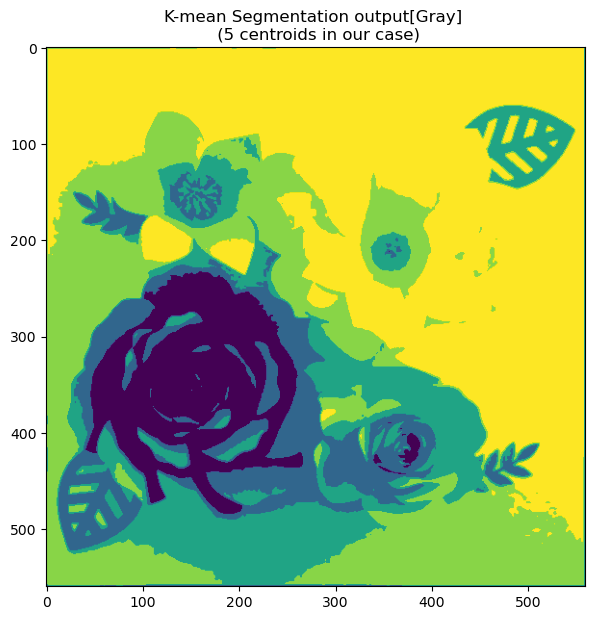

In [10]:
## Comparison With Two More Advanced Segmentation Algorithms(Using Modules For These)

## 4. K-Mean clustering Based Segmentation

input_image = noise_removed_image.reshape((-1))
input_image = np.float32(input_image)
criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
num_of_clusters = 5
ret1, label1, center1 = cv2.kmeans(input_image, num_of_clusters, None, criteria, 15, cv2.KMEANS_PP_CENTERS )
center = np.uint8(center1)
reshape = center[label1.flatten()]
reshaped_image = reshape.reshape((noise_removed_image.shape))
fig = plt.figure(figsize = (7,7))
plt.imshow(reshaped_image)
plt.title("K-mean Segmentation output[Gray] \n (5 centroids in our case)")
plt.show()


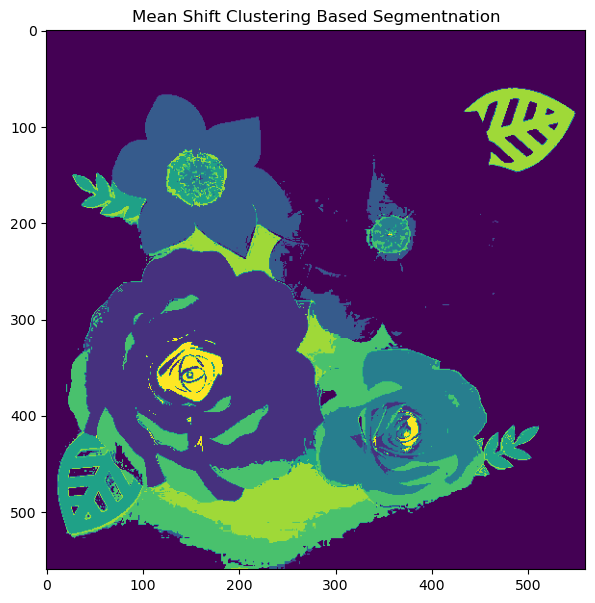

In [11]:
# 5. Mean Shift

from sklearn.cluster import MeanShift, estimate_bandwidth

input_image = my_image.reshape((-1,3))
input_image = np.float32(input_image)
bandwidth = estimate_bandwidth(input_image, quantile =0.1, n_samples=100)
mean_shift_fit = MeanShift(bandwidth=bandwidth, bin_seeding =True)
mean_shift_fit.fit(input_image)
labels = mean_shift_fit.labels_
output_image_meanshift = np.reshape(labels, my_image.shape[:2])
fig = plt.figure(figsize=(7,7))
plt.imshow(output_image_meanshift)
plt.title("Mean Shift Clustering Based Segmentnation")
plt.show()